In [1]:
!python -V
!pip show tensorflow

Python 3.8.8
Name: tensorflow
Version: 2.3.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\b\appdata\local\programs\python\python38\lib\site-packages
Requires: keras-preprocessing, protobuf, grpcio, h5py, termcolor, wrapt, opt-einsum, google-pasta, astunparse, gast, numpy, wheel, tensorflow-estimator, six, absl-py, tensorboard, scipy
Required-by: 


In [2]:
import io
import glob
import yaml
import random

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette(palette='magma', n_colors=3)
sns.set_style("darkgrid")

import tensorflow as tf
from lib.utils import load_graph_data
from model.gcnn_supervisor import GCNNSupervisor

c:\users\b\desktop\adversarial_traffic_flow\adversarial_gc_grnn\env\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\b\desktop\adversarial_traffic_flow\adversarial_gc_grnn\env\lib\site-packages\tensorflow\python\framework\dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\b\desktop\adversarial_traffic_flow\adversarial_gc_grnn\env\lib\site-packages\tensorflow\python\framework\dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("q

In [3]:
SEED = 101
random.seed(SEED)
np.random.seed(SEED)

In [4]:
# get scalers
training_set = np.load('./data/train.npz')

mean = round(training_set['x'][...,0].mean(), 2)
std = round(training_set['x'][...,0].std(), 2)

print("Mean ={}, Std = {}".format(mean, std))

Mean =4090.28, Std = 2164.09


In [5]:
# Adversarial inputs 
adv_flow = np.expand_dims(np.load('./aes/adv_bim.npy', allow_pickle = True), axis = 3)
print(f'Inpts: shape= {adv_flow.shape}, Max = {np.max(adv_flow)}')

# ground truths (extracting from outputs on real test inputs)
gts = np.load('./data/test.npz')['y']
print(f'GTs: shape= {gts.shape}, Max = {np.max(gts)}')

# They all need to be denormalized
adv_flow = adv_flow*std + mean
print(f'\nInputs: shape= {adv_flow.shape}, Max = {np.max(adv_flow)}')

Inpts: shape= (2616, 12, 150, 1), Max = 3.490483283996582
GTs: shape= (2616, 12, 150, 1), Max = 11644.0

Inputs: shape= (2616, 12, 150, 1), Max = 11644.0


In [6]:
x_offsets = np.sort(np.concatenate((np.arange(-11, 1, 1),)))
y_offsets = np.sort(np.arange(1, 13, 1))
    
np.savez_compressed(
            './data_bim/test.npz', # The file has to be named test.npz, also train and val data npz files have to be kept on same folder
            x=adv_flow,
            y=gts,
            x_offsets=x_offsets.reshape(list(x_offsets.shape) + [1]),
            y_offsets=y_offsets.reshape(list(y_offsets.shape) + [1]),)

In [7]:
# create yaml file for adversarial flow

# common, since we have only 50 AEs for CW, I changed test batch size to 32
# the model will have 2 files, index and data 
best_model_dir = './best_model/'
name_splits = glob.glob(best_model_dir+'*.index')[0].split('.')
model_filename = '.'+name_splits[1] + '.'+ name_splits[2]
print("The model being used for predictions is:",model_filename)

# only required for training, 
predictions_file=''
ground_truths_file=''

# BIM
configuration = {'base_dir' : 'results',
                 'log_level':'INFO',
                 'data':{'batch_size': 32,
                           'dataset_dir': './data_bim/',
                           'graph_pkl_filename': './helper_files/adj_mat_volume.pkl',
                           'test_batch_size': 64,
                           'val_batch_size': 64},
                 'model':{'cl_decay_steps': 2000,
                           'horizon': 12,
                           'input_dim': 1,
                           'l1_decay': 0 ,
                           'num_nodes': 150,
                           'num_rnn_layers': 1,
                           'output_dim': 1,
                           'rnn_units': 128,
                           'seq_len': 12,
                           'use_curriculum_learning': True},
                'train':{'base_lr': 0.01,
                          'dropout': 0,
                          'epoch': 0,
                          'epochs': 300,
                          'epsilon': 1.0e-3,
                          'global_step': 0,
                          'lr_decay_ratio': 0.1,
                          'max_grad_norm': 5,
                          'max_to_keep': 100,
                          'min_learning_rate': 2.0e-06,
                          'model_filename': model_filename,
                          'optimizer': 'adam',
                          'patience': 50,
                          'steps': '[20]',
                          'test_every_n_epochs': 1,
                          'preds_file': predictions_file ,
                          'groundtruth_file':ground_truths_file}
                }
                
# Write BIM YAML file
config_file_name_bim = './data_bim/config_for_pre_trained_gcnn_bim.yaml'
with io.open(config_file_name_bim, 'w', encoding='utf8') as outfile:
    yaml.dump(configuration, outfile, default_flow_style=False, allow_unicode=True)

The model being used for predictions is: ./best_model\models-325.1414-29274


In [8]:
# Predictions of GCGRNN model in adversarial data 
# Helper

def run_gcnn(config_file, output_file, use_gpu = False ):
    
    # safely load the config yaml file
    with open(config_file, 'r') as f:
        try: 
            cfile = yaml.safe_load(f)
        except yaml.YAMLError as exc:
            print(exc)
    
    #with open(config_file) as f:
        #cfile = yaml.load(f)
    
    # some GPU config settings with TF        
    tf_config = tf.ConfigProto()
    if use_gpu:
        tf_config = tf.ConfigProto(device_count={'GPU': 0})
    tf_config.gpu_options.allow_growth = True
    
    # load the adjacency matrix graph pickle
    graph_pkl_filename = cfile['data']['graph_pkl_filename']
    _, _, adj_mx = load_graph_data(graph_pkl_filename)
    
    with tf.Session(config=tf_config) as sess:

        # Instantiate a supervisor with adjacency matrix and config
        supervisor = GCNNSupervisor(adj_mx=adj_mx, **cfile)

        #load the best-model 
        supervisor.load(sess, cfile['train']['model_filename'])

        # get model output
        outputs = supervisor.evaluate(sess)

        # save the predicsions to file
        np.savez_compressed(output_file, **outputs)
        print('Predictions saved as {}.'.format(output_file))

In [9]:
# just to make the files work, put the train.npz and val.npz files in adversarial_flow_bim and adversarial_flowcw folders
# They are not used, just for print statements and others

# Actual predictions
bim_output_filename = './data_bim/bim_gcgrnn_output.npz'

# If you do not have a GPU, set the use_gpu option to False
# predictions for bim
run_gcnn(config_file_name_bim, bim_output_filename, use_gpu = True) 

2021-03-28 21:23:16,759 - INFO - Log directory: results\GCNN_DDGF_h_12_128_lr_0.01_bs_32_0328212316/
2021-03-28 21:23:16,760 - INFO - {'adj_mx': array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'base_dir': 'results', 'data': {'batch_size': 32, 'dataset_dir': './data_bim/', 'graph_pkl_filename': './helper_files/adj_mat_volume.pkl', 'test_batch_size': 64, 'val_batch_size': 64}, 'log_level': 'INFO', 'model': {'cl_decay_steps': 2000, 'horizon': 12, 'input_dim': 1, 'l1_decay': 0, 'num_nodes': 150, 'num_rnn_layers': 1, 'output_dim': 1, 'rnn_units': 128, 'seq_len': 12, 'use_curriculum_learning': True}, 'train': {'base_lr': 0.01, 'dropout': 0, 'epoch': 0, 'epochs': 300, 'epsilon': 0.001, 'global_step': 0, 'groundtruth_file': '', 'lr_decay_ratio': 0.1, 'max_grad_norm': 5, 'max_to_keep': 100

In [10]:
# inputs
inputs = np.squeeze(np.load('./data/test.npz')['x'])
print(f'Inputs: shape= {inputs.shape}, Max = {np.max(inputs)}')

# ground truths
gts = np.squeeze(np.load('./data/test.npz')['y'])
print(f'GTs: shape= {gts.shape}, Max = {np.max(gts)}')

# predictions on inputs
test_op = np.load('./best_model/best_model_output.npz')
test_preds = np.squeeze(test_op['predictions'][0:2616])
print(f'\nPreds on Test Inputs: shape= {test_preds.shape}, Max = {np.max(test_preds)}')

# Corresponding AEs
adv_flow = np.load('./aes/adv_bim.npy', allow_pickle = True)
print(f'AEs: shape= {adv_flow.shape}, Max = {np.max(adv_flow)}')

# Predictions on AEs
aes_op = np.load('./data_bim/bim_gcgrnn_output.npz')
aes_preds = np.squeeze(aes_op['predictions'][0:2616])
print(f'Preds on AEs from test inputs: shape= {aes_preds.shape}, Max = {np.max(aes_preds)}')

# Make sure everything is denormmalized 
test_preds = test_preds*std + mean
adv_flow = adv_flow*std + mean
aes_preds = aes_preds*std + mean

print(f'\nPreds on Test Inputs: shape= {test_preds.shape}, Max = {np.max(test_preds)}')
print(f'AEs: shape= {adv_flow.shape}, Max = {np.max(adv_flow)}')
print(f'Preds on AEs from test inputs: shape= {aes_preds.shape}, Max = {np.max(aes_preds)}')

Inputs: shape= (2616, 12, 150), Max = 11644.0
GTs: shape= (2616, 12, 150), Max = 11644.0

Preds on Test Inputs: shape= (2616, 12, 150), Max = 3.3234169483184814
AEs: shape= (2616, 12, 150), Max = 3.490483283996582
Preds on AEs from test inputs: shape= (2616, 12, 150), Max = 3.5044546127319336

Preds on Test Inputs: shape= (2616, 12, 150), Max = 11282.4541015625
AEs: shape= (2616, 12, 150), Max = 11644.0
Preds on AEs from test inputs: shape= (2616, 12, 150), Max = 11674.2353515625


### GC_GRNN error distribution on AEs vs Corresponding inputs

In [11]:
def get_metrics(pred, truth):
    
    # assert both have same lengths
    num_signals = len(pred)
    #print(num_signals)
    
    number_of_nodes = 150
    time_steps = 12

    rmse_collect = []
    rmse = 0.0
    
    for i in range(num_signals):
        rmse_signal = np.sum(np.square(pred[i]- truth[i]))
        
        # save this to true rmse first
        rmse+= rmse_signal
        
        # arrange to collect
        rmse_signal = np.sqrt(rmse_signal/(time_steps*number_of_nodes))
        
        # collect it
        rmse_collect.append(round(rmse_signal,2))
        

    rmse = np.sqrt(rmse/(num_signals*time_steps*number_of_nodes))
    #print(rmse)
    rmse_collect = np.array(rmse_collect)
    
    return rmse, rmse_collect

In [12]:
rmse_original, RMSE_collect_preds_on_inputs = get_metrics(test_preds, gts)

print("Originals: True RMSE: ", round(rmse_original,2))

print("\nSignal wise collection: ")
print(f'Max ={np.max(RMSE_collect_preds_on_inputs)}, Mean={round(np.mean(RMSE_collect_preds_on_inputs),2)}, Shape={RMSE_collect_preds_on_inputs.shape}')

Originals: True RMSE:  529.88

Signal wise collection: 
Max =2112.04, Mean=512.73, Shape=(2616,)


In [13]:
rmse_aes, RMSE_collect_preds_on_aes = get_metrics(aes_preds, gts)

print("AEs: True RMSE: ", round(rmse_aes,2))

print("\nSignal wise collection: ")
print(f'Max ={np.max(RMSE_collect_preds_on_aes)}, Mean={round(np.mean(RMSE_collect_preds_on_aes),2)}, Shape={RMSE_collect_preds_on_aes.shape}')

AEs: True RMSE:  607.14

Signal wise collection: 
Max =1903.22, Mean=580.33, Shape=(2616,)


Text(0, 0.5, 'Number of signals')

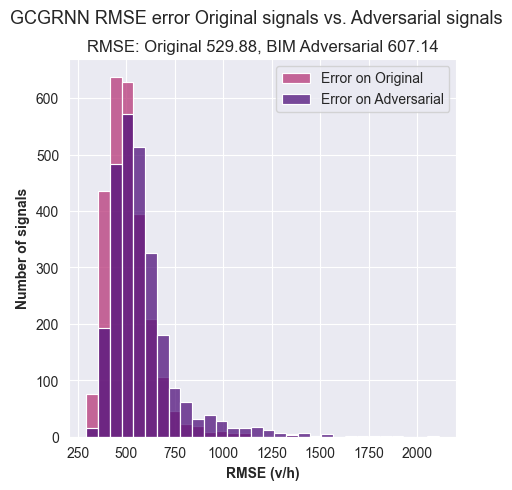

In [14]:
# RMSE Error distribution shift
#mean_rmse_inputs = np.mean(RMSE_collect_preds_on_inputs)
#mean_rmse_aes = np.mean(RMSE_collect_preds_on_aes)

labels =["Error on Original","Error on Adversarial"]
fig, axes =plt.subplots(figsize=(5,5),dpi=100)
fig.suptitle('GCGRNN RMSE error Original signals vs. Adversarial signals', fontsize=13)

rmse_plot = sns.histplot(data=[RMSE_collect_preds_on_aes, RMSE_collect_preds_on_inputs], bins=30, kde=False, fill=True)
axes.set_title('RMSE: Original {}, BIM Adversarial {}'.format(str(round(rmse_original,2)), str(round(rmse_aes,2))))
axes.legend(labels)
axes.set_xlabel('RMSE (v/h)', fontweight='bold')
axes.set_ylabel('Number of signals', fontweight='bold')

In [15]:
np.save("./common_viz/dstr_bim.npy",RMSE_collect_preds_on_aes)
np.save("./common_viz/dstr_orig.npy",RMSE_collect_preds_on_inputs)

In [16]:
#14.58%

### For GCGRNN: Input, Corresponding AEs, Ground Truth, Prediction on input, Prediction on AE 

In [17]:
np.argwhere(2*RMSE_collect_preds_on_inputs < RMSE_collect_preds_on_aes)

array([[ 125],
       [ 149],
       [ 173],
       [ 174],
       [ 176],
       [ 222],
       [ 225],
       [ 226],
       [ 239],
       [ 270],
       [ 293],
       [ 317],
       [ 318],
       [ 320],
       [ 321],
       [ 341],
       [ 365],
       [ 393],
       [ 415],
       [ 417],
       [ 438],
       [ 461],
       [ 533],
       [ 534],
       [ 561],
       [ 581],
       [ 586],
       [ 587],
       [ 605],
       [ 606],
       [ 629],
       [ 677],
       [ 680],
       [ 702],
       [ 727],
       [ 797],
       [ 845],
       [ 848],
       [ 875],
       [ 920],
       [1020],
       [1037],
       [1038],
       [1043],
       [1088],
       [1133],
       [1157],
       [1158],
       [1232],
       [1234],
       [1256],
       [1259],
       [1263],
       [1274],
       [1278],
       [1325],
       [1373],
       [1374],
       [1375],
       [1402],
       [1425],
       [1446],
       [1493],
       [1517],
       [1568],
       [1570],
       [16

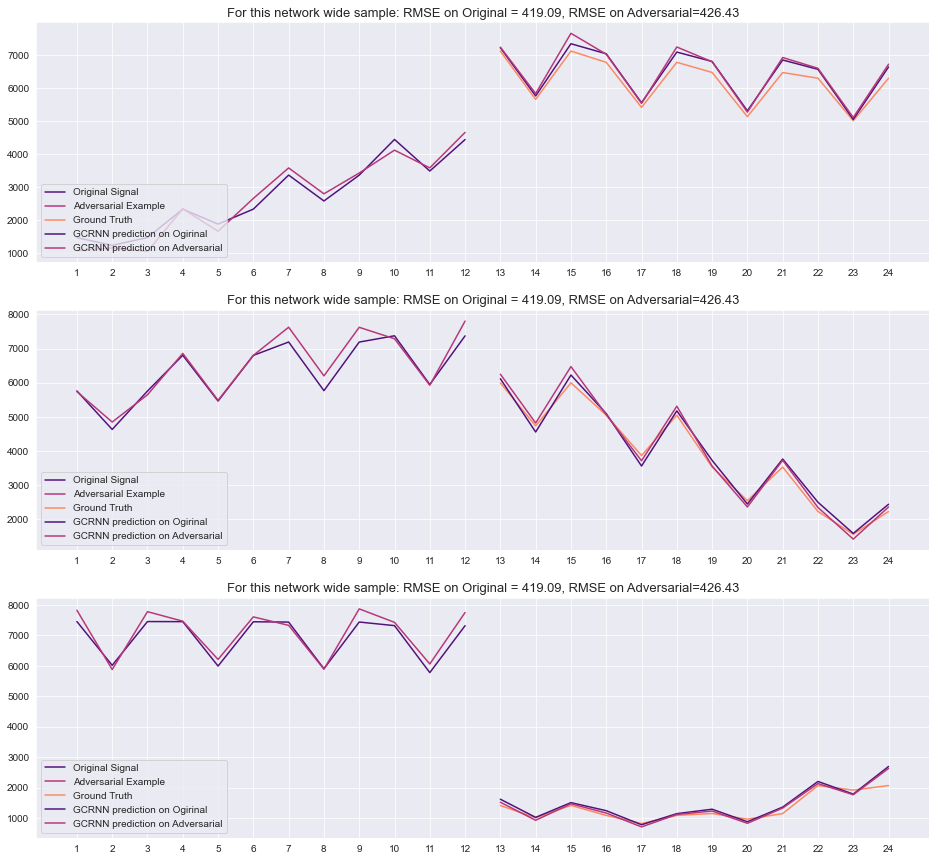

In [18]:
# Do some predictions with the trained model and observe outputs
# Plot corresponding input and corresponding (ResNet Pred, GC-GRNN pred, GT) 
data_select = 100

inpt = inputs[data_select]
gt = gts[data_select]
ae = adv_flow[data_select]
gcgrnn_input_pred = test_preds[data_select]
gcgrnn_ae_pred = aes_preds[data_select]

er_input = RMSE_collect_preds_on_inputs[data_select]
er_ae = RMSE_collect_preds_on_aes[data_select]

num = 3
inpt = inpt[:,0:num].reshape(num,12)
gt = gt [:,0:num].reshape(num,12)
ae = ae[:,0:num].reshape(num,12)
gcgrnn_input_pred = gcgrnn_input_pred[:,0:num].reshape(num,12)
gcgrnn_ae_pred = gcgrnn_ae_pred[:,0:num].reshape(num,12)

total_x = np.arange(1,25,1)
x_pred = np.arange(13,25,1)
x_inpt = np.arange(1,13,1)

fig, ax = plt.subplots(num,1,figsize=(16,num*5))
legend_array = ["Original Signal",
              "Adversarial Example",
              "Ground Truth", 
              "GCRNN prediction on Ogirinal",
              "GCRNN prediction on Adversarial" ]

# 0
ax[0].plot(x_inpt,inpt[0])
ax[0].plot(x_inpt,ae[0])

ax[0].plot(x_pred,gt[0])
ax[0].plot(x_pred,gcgrnn_input_pred[0])
ax[0].plot(x_pred,gcgrnn_ae_pred[0])

ax[0].set_title(f'For this network wide sample: RMSE on Original = {er_input}, RMSE on Adversarial={er_ae}', fontsize=13);
ax[0].set_xticks(total_x);
ax[0].legend(legend_array, loc='lower left')

# 1
ax[1].plot(x_inpt,inpt[1])
ax[1].plot(x_inpt,ae[1])

ax[1].plot(x_pred,gt[1])
ax[1].plot(x_pred,gcgrnn_input_pred[1])
ax[1].plot(x_pred,gcgrnn_ae_pred[1])

ax[1].set_title(f'For this network wide sample: RMSE on Original = {er_input}, RMSE on Adversarial={er_ae}', fontsize=13);
ax[1].set_xticks(total_x);
ax[1].legend(legend_array, loc='lower left')

# 2
ax[2].plot(x_inpt,inpt[2])
ax[2].plot(x_inpt,ae[2])

ax[2].plot(x_pred,gt[2])
ax[2].plot(x_pred,gcgrnn_input_pred[2])
ax[2].plot(x_pred,gcgrnn_ae_pred[2])

ax[2].set_title(f'For this network wide sample: RMSE on Original = {er_input}, RMSE on Adversarial={er_ae}', fontsize=13);
ax[2].set_xticks(total_x);
ax[2].legend(legend_array, loc='lower left')

### Common Metric

In [19]:
# define a common metric
def measure_l2(one, two):
    # Both will be 150*12 network wide snapshots
    one = np.squeeze(np.array(one))
    two = np.squeeze(np.array(two))
    l2 = np.sum(np.square(one-two))
    return l2

def notation(number):
    str_num = str(number)
    splits = str_num.split('.')
    leng = int(len(splits[0]))-1
    divisor = 1
    for i in range(leng):
        divisor = divisor*10
    changed_num = round((number/divisor),2)
    return changed_num, leng

Signal: shape = (2616,), max = 228697095.22172266
Signal: shape = (2616,), max = 4766280704.0


(-100000000.0, 2000000000.0)

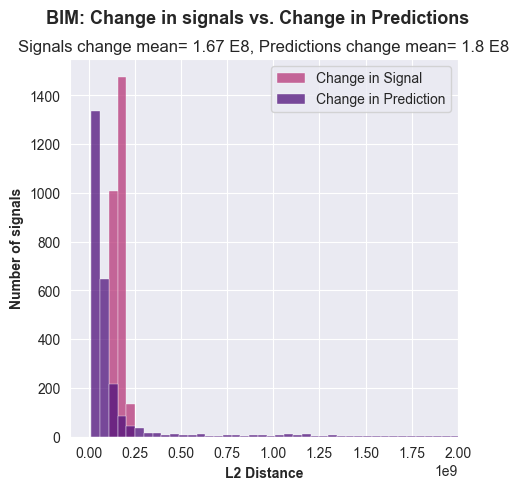

In [20]:
# measure change
# Change made in signal vs. Change made in prediction as measured by L2 distance

# change in signal
sig_change_collect = []
for i in range(len(inputs)):
    sig_change = measure_l2(inputs[i], adv_flow[i])
    sig_change_collect.append(sig_change)
sig_change_collect = np.array(sig_change_collect)
print(f'Signal: shape = {sig_change_collect.shape}, max = {np.max(sig_change_collect)}' )

# change in prediction
pred_change_collect = []
for j in range(len(test_preds)):
    pred_change = measure_l2(test_preds[j], aes_preds[j])
    pred_change_collect.append(pred_change)
pred_change_collect = np.array(pred_change_collect)
print(f'Signal: shape = {pred_change_collect.shape}, max = {np.max(pred_change_collect)}' )

# report average
# RMSE Error distribution shift
mean_signal_change= np.mean(sig_change_collect)
mean_pred_change = np.mean(pred_change_collect)

num1, exp1 = notation(mean_signal_change)
num2, exp2 = notation(mean_pred_change)

m1 = str(num1) + " E" + str(exp1)
m2 = str(num2) + " E" + str(exp2)

labels =["Change in Signal","Change in Prediction"]
fig, axes =plt.subplots(figsize=(5,5),dpi=100)
fig.suptitle('BIM: Change in signals vs. Change in Predictions', fontsize=13, fontweight='bold')

rmse_plot = sns.histplot(data=[pred_change_collect, sig_change_collect], bins=100, kde=False, fill=True)
axes.set_title('Signals change mean= {}, Predictions change mean= {}'.format(m1, m2))
axes.legend(labels)
axes.set_xlabel('L2 Distance', fontweight='bold')
axes.set_ylabel('Number of signals', fontweight='bold')
axes.set_xlim(-100000000.0, 2000000000.0)

In [21]:
# change in prediction is higher than the change in signal
print("Change in signals\nMax = {}, \nMin = {}".format(np.max(sig_change_collect), np.min(sig_change_collect)))
print("Mean = {}".format(np.mean(sig_change_collect)))
# very little variance with a mean of 3.35x10^8

Change in signals
Max = 228697095.22172266, 
Min = 113736678.00828612
Mean = 167372122.6005517


In [22]:
print("Change in Preds\nMax = {}, \nMin = {}".format(np.max(pred_change_collect), np.min(pred_change_collect)))
print("Mean = {}".format(np.mean(pred_change_collect)))

Change in Preds
Max = 4766280704.0, 
Min = 13923931.0
Mean = 179825280.0
